In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize ,
                         poly ,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [2]:
from pygam import (s as s_gam ,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM ,
                   LogisticGAM)
from ISLP.transforms import (BSpline ,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam ,
                        degrees_of_freedom ,
                        plot as plot_gam ,
                        anova as anova_gam)

# 7.8.1 Polynomial Regression and Step Functions

In [3]:
# loading data
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [4]:
# polynomial regression
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [5]:
# range of 100 values of age
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})

In [6]:
age_df

,age
0,18.000000
1,18.626263
2,19.252525
3,19.878788
4,20.505051
...,...
95,77.494949
96,78.121212
97,78.747475
98,79.373737


In [7]:
# plotting predictions for the age values
def plot_wage_fit(age_df ,
                  basis ,
                  title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig , ax = subplots(figsize=(8,8))
    ax.scatter(age ,
                y,
                facecolor='gray',
                alpha=0.5)   # controls opacity -> density
    # 3 line plots
    for val , ls in zip([preds.predicted_mean ,
                        bands[:,0],
                        bands[:,1]],
                        ['b','r--','r--']):
        ax.plot(age_df.values , val , ls, linewidth=3)
    ax.set_title(title , fontsize =20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

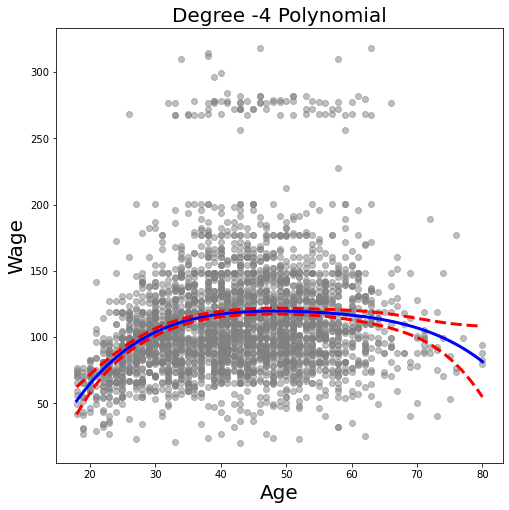

In [8]:
plot_wage_fit(age_df ,
              poly_age ,
              'Degree -4 Polynomial');

In [9]:
# comparison of models with different polynomial degrees
models = [MS([poly('age', degree=d)])
          for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [10]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [11]:
models = [MS(['education', poly('age', degree=d)])
              for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
        for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


Can also use cross-validation to choose the polynomial degree instead

In [12]:
# logistic regression to predict high earners
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250,
             X,
             family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [13]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

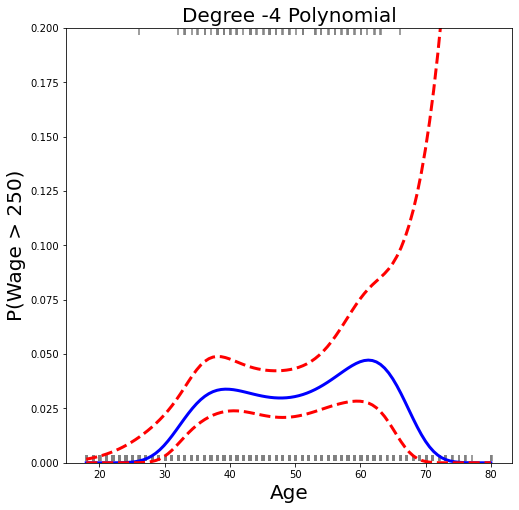

In [14]:
fig , ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn , 0.198, 0.002),
           fc='gray',
           marker='|')
for val , ls in zip([preds.predicted_mean ,
                    bands[:,0],
                    bands[:,1]],
                    ['b','r--','r--']):
    ax.plot(age_df.values , val , ls, linewidth=3)
ax.set_title('Degree -4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim ([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

In [15]:
# using quantiles to create cutpoints
cut_age = pd.qcut(age , 4)
cut_age

0       (17.999, 33.75]
1       (17.999, 33.75]
2          (42.0, 51.0]
3          (42.0, 51.0]
4          (42.0, 51.0]
             ...       
2995       (42.0, 51.0]
2996    (17.999, 33.75]
2997    (17.999, 33.75]
2998    (17.999, 33.75]
2999       (51.0, 80.0]
Name: age, Length: 3000, dtype: category
Categories (4, interval[float64, right]): [(17.999, 33.75] < (33.75, 42.0] < (42.0, 51.0] < (51.0, 80.0]]

In [16]:
# fitting step function
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


# 7.8.2 Splines

In [17]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [18]:
# matrix of basis functions
bs_age

,"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[0]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[1]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[2]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[3]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[4]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[5]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[6]"
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.002915,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,0.000000,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,0.000000,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,0.000000,0.000000,0.034014,0.508194,0.426542,0.031250,0.0
...,...,...,...,...,...,...,...
2995,0.000000,0.000000,0.139320,0.628472,0.230208,0.002000,0.0
2996,0.000000,0.137741,0.629111,0.228819,0.004329,0.000000,0.0
2997,0.000000,0.302617,0.586851,0.110255,0.000277,0.000000,0.0
2998,0.000000,0.302617,0.586851,0.110255,0.000277,0.000000,0.0


In [19]:
# fitting cubic spline
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In [20]:
# using column names
bs_age = MS([bs('age',
                internal_knots=[25,40,60],
                name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


In [21]:
# specifying degrees of freedom
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [22]:
# specifying the degree
bs_age0 = MS([bs('age',
              df=3,
              degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


In [23]:
# fitting natural spline
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


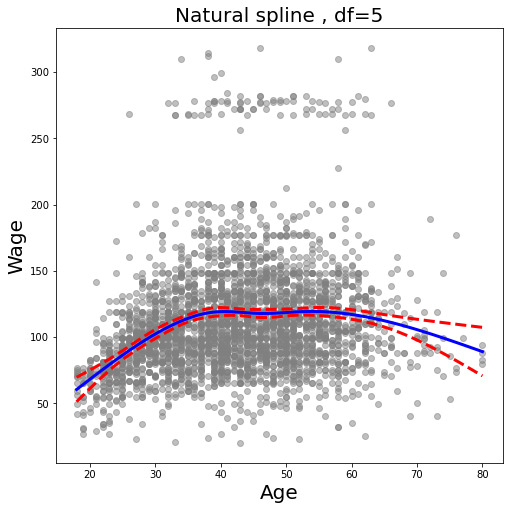

In [24]:
plot_wage_fit(age_df ,
              ns_age ,
              'Natural spline , df=5');

# 7.8.3 Smoothing Splines and GAMs

In [25]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age , y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

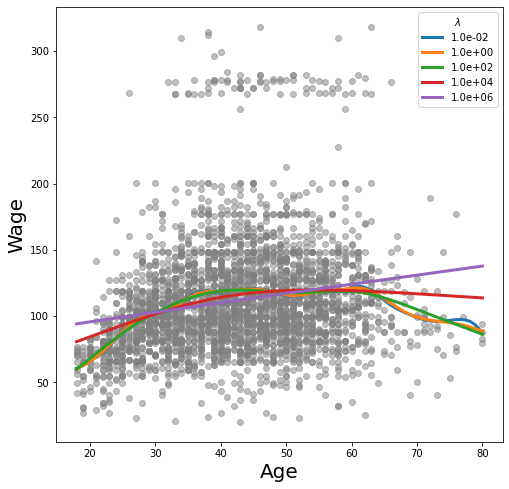

In [26]:
fig , ax = subplots(figsize=(8,8))
ax.scatter(age , y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age , y)
    ax.plot(age_grid ,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


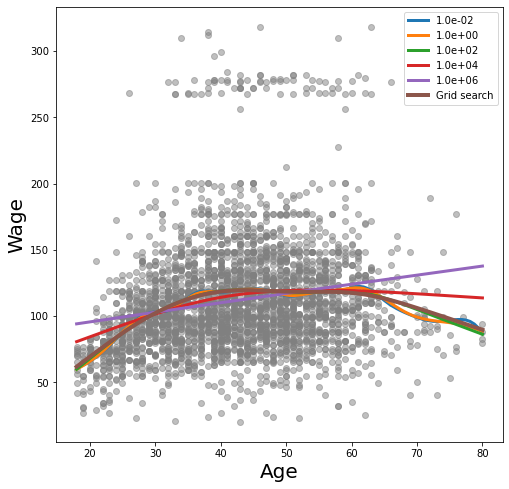

In [27]:
# search for best smoothing parameter
gam_opt = gam.gridsearch(X_age , y)
ax.plot(age_grid ,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

In [28]:
# fixing degrees of freedom
age_term = gam.terms[0]
lam_4 = approx_lam(X_age , age_term , 4)
age_term.lam = lam_4
degrees_of_freedom(X_age , age_term)

4.0000001000025565

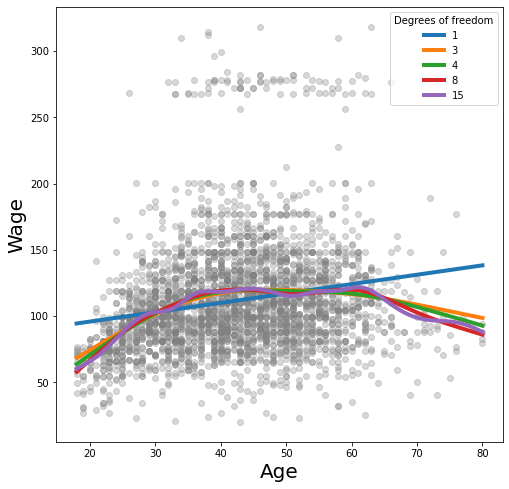

In [29]:
# plot for different dof
fig , ax = subplots(figsize=(8,8))
ax.scatter(X_age ,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age , age_term , df+1)
    age_term.lam = lam
    gam.fit(X_age , y)
    ax.plot(age_grid ,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');

## Additive Models with Several Terms

In [30]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

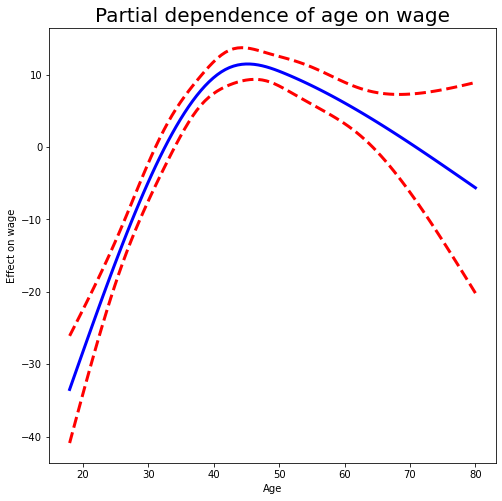

In [31]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None ,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig , ax = subplots(figsize=(8,8))
ax.plot(age_grid , partial_age , 'b', linewidth=3)
ax.plot(age_grid , bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid , bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

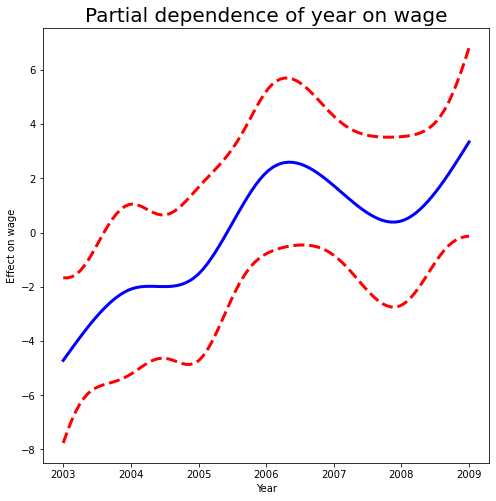

In [32]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None ,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha =0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig , ax = subplots(figsize=(8,8))
ax.plot(year_grid , partial_year , 'b', linewidth=3)
ax.plot(year_grid , bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid , bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

In [33]:
gam_full = LinearGAM(s_gam(0) +
                    s_gam(1, n_splines=7) +
                    f_gam(2, lam=0))
                    Xgam = np.column_stack([age ,
                    Wage['year'],
                    Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam , y)

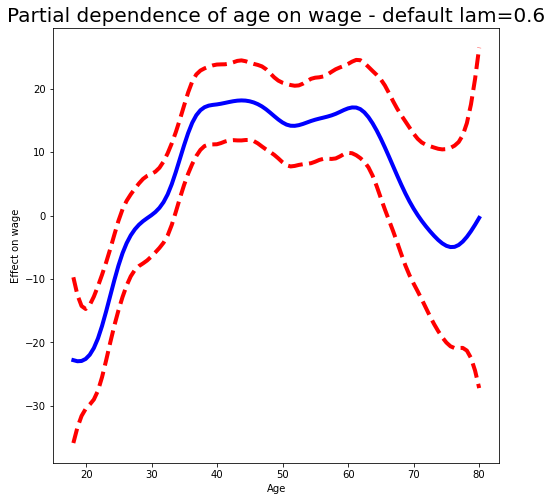

In [34]:
fig , ax = subplots(figsize=(8,8))
plot_gam(gam_full , 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6',
              fontsize=20);

In [49]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam , age_term , df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam , year_term , df=4+1)
gam_full = gam_full.fit(Xgam , y)

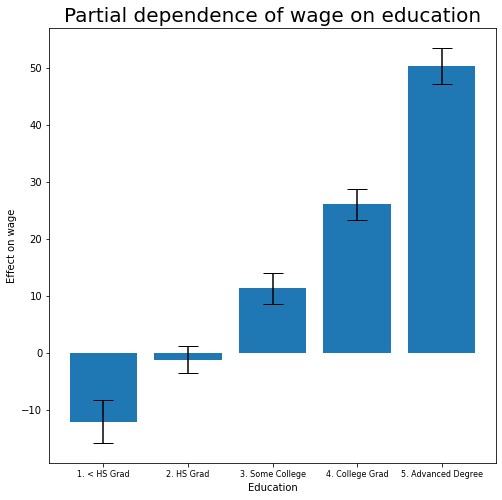

In [35]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full , 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize =20);
ax.set_xticklabels(Wage['education'].cat.categories , fontsize =8);

## ANOVA Tests for Additive Models

In [36]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam , y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0) +
                       f_gam(2, lam=0))
gam_linear.fit(Xgam , y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [37]:
# comparing GAMs
anova_gam(gam_0 , gam_linear , gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.703321e+06,2980.002360,NaN,NaN,NaN,NaN
1,3.685094e+06,2979.003169,18226.315462,0.999191,14.749966,0.000799
2,3.680640e+06,2976.214249,4453.833907,2.788920,1.291335,0.299541


In [38]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.7858
Link Function:                     IdentityLink Log Likelihood:                                -24118.5887
Number of Samples:                         3000 AIC:                                            48286.7489
                                                AICc:                                           48287.1787
                                                GCV:                                             1254.5772
                                                Scale:                                           1236.6853
                                                Pseudo R-Squared:                                   0.2952
Feature Function                  Lam

C:\Users\Amruthaa\AppData\Local\Temp\ipykernel_10936\3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [39]:
# making training predictions
Yhat = gam_full.predict(Xgam)

In [40]:
# fitting Logistic Regression GAM
gam_logit = LogisticGAM(age_term +
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam , high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

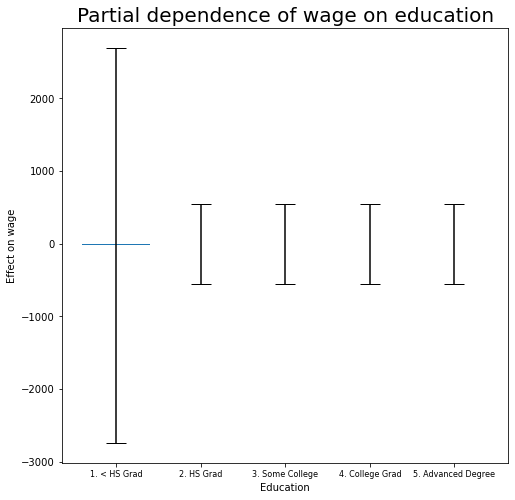

In [41]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit , 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
              fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories , fontsize=8);

In [42]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [44]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
                        Wage_['year'],
                        Wage_['education'].cat.codes -1])
high_earn_ = Wage_['high_earn']

In [51]:
gam_logit_ = LogisticGAM(age_term +
                        year_term +
                        f_gam(2, lam=0))
gam_logit_.fit(Xgam_ , high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

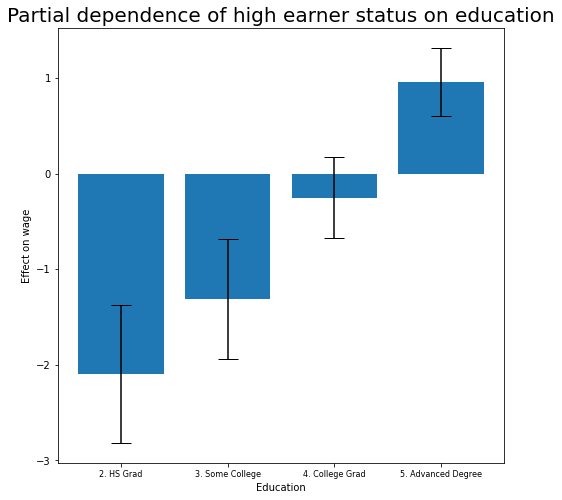

In [52]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_ , 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:],
fontsize=8);

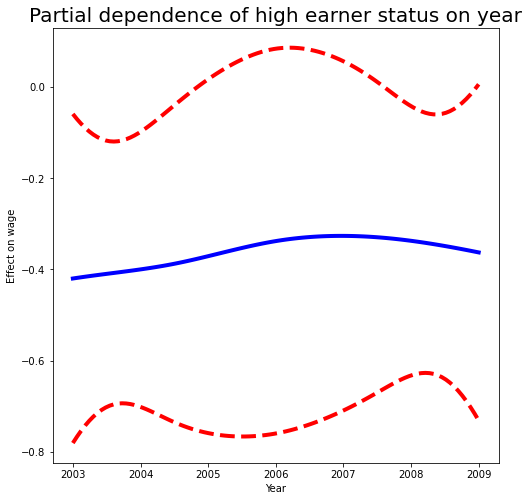

In [53]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_ , 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',
             fontsize=20);

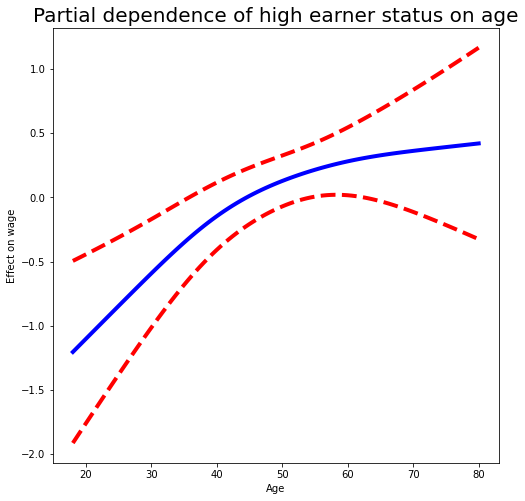

In [54]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_ , 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age',
              fontsize=20);

# 7.8.4 Local Regression

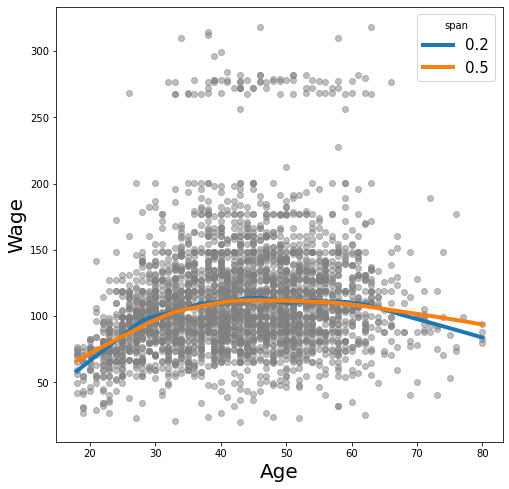

In [55]:
# using spans of 0.2 and 0.5
lowess = sm.nonparametric.lowess
fig , ax = subplots(figsize=(8,8))
ax.scatter(age , y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age ,
                    frac=span ,
                    xvals=age_grid)
    ax.plot(age_grid ,
            fitted ,
            label='{:.1f}'.format(span),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);